### Högbom's Method

An implementation of Högbom's `CLEAN` deconvolution method. Requires FITS images of dirty image and PSF. Assumes single polarization, single frequency.

Pseeudo-code:

$\textbf{input: } I^{D}(l,m), \ \textrm{PSF}(l,m), \ \gamma, \ f_{\textrm{thresh}}, \ N$

$\textbf{initialize: } S^{\textrm{model}} \leftarrow \{\}, I^{\textrm{res}} \leftarrow I^{D}, i \leftarrow 0$

$\textbf{while} \ \textrm{any}(I^{\textrm{res}} > f_{\textrm{thresh}}) \ \textrm{or} \ i \leq N \ \textbf{do:}$

$\qquad l_{\textrm{max}}, m_{\textrm{max}} \leftarrow \underset{l,m}{\operatorname{argmax}} I^{\textrm{res}}(l,m)$

$\qquad f_{\textrm{max}} \leftarrow I^{D}(l_{\textrm{max}}, m_{\textrm{max}})$

$\qquad I^{\textrm{res}} \leftarrow I^{\textrm{res}} - \gamma \cdot f_{\textrm{max}} \cdot \textrm{PSF}(l+l_{\textrm{max}}, m+m_{\textrm{max}})$

$\qquad S^{\textrm{model}} \leftarrow S^{\textrm{model}} + \{l_{\textrm{max}}, m_{\textrm{max}}: \gamma \cdot f_{\textrm{max}}\}$

$\qquad i \leftarrow i +1$

$\textbf{ouput: } S^{\textrm{model}}, I^{\textrm{res}}$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import optimize

from astropy.io import fits
import aplpy

#Disable astropy/aplpy logging
import logging
logger0 = logging.getLogger('astropy')
logger0.setLevel(logging.CRITICAL)
logger1 = logging.getLogger('aplpy')
logger1.setLevel(logging.CRITICAL)

In [23]:
def subtractPSF(img, psf, l, m, flux, gain):
    """Subtract the PSF (attenuated by the gain and flux) centred at (l,m) from an image"""
    
    #get the half lengths of the PSF
    if (psf.shape[0] % 2 == 0): psfMidL = psf.shape[0]//2 #even
    else: psfMidL = (psf.shape[0]+1)//2 #odd
    if (psf.shape[1] % 2 == 0): psfMidM = psf.shape[1]//2 #even
    else: psfMidM = (psf.shape[1]+1)//2 #odd
    
    #determine limits of sub-images
    #starting m
    if m-psfMidM < 0:
        subM0 = 0
        subPSFM0 = psfMidM-m
    else:
        subM0 = m-psfMidM
        subPSFM0 = 0
    #starting l
    if l-psfMidL < 0:
        subL0 = 0
        subPSFL0 = psfMidL-l
    else:
        subL0 = l-psfMidL
        subPSFL0 = 0
    #ending m
    if img.shape[1] > m+psfMidM:
        subM1 = m+psfMidM
        subPSFM1 = psf.shape[1]
    else:
        subM1 = img.shape[1]
        subPSFM1 = psfMidM + (img.shape[1]-m)
    #ending l
    if img.shape[0] > l+psfMidL:
        subL1 = l+psfMidL
        subPSFL1 = psf.shape[0]
    else:
        subL1 = img.shape[0]
        subPSFL1 = psfMidL + (img.shape[0]-l)
    
    #select subset of image
    #subImg = img[subL0:subL1, subM0:subM1]
    #select subset of PSF
    subPSF = psf[subPSFL0:subPSFL1, subPSFM0:subPSFM1]
    
    #subtract PSF centred on (l,m) position
    img[subL0:subL1, subM0:subM1] -= flux * gain * psf[subPSFL0:subPSFL1, subPSFM0:subPSFM1]
    return img

In [24]:
def gauss2D(x, y, amp, meanx, meany, sigmax, sigmay):
    """2D Gaussian Function"""
    gx = -(x - meanx)**2/(2*sigmax**2)
    gy = -(y - meany)**2/(2*sigmay**2)
    
    return amp * np.exp( gx + gy)

def err(p, xx, yy, data):
    """Error function for least-squares fitting"""
    return gauss2D(xx.flatten(), yy.flatten(), *p) - data.flatten()

def idealPSF(psfImg):
    """Determine the ideal PSF size based on the observing PSF doing a simple 2D Gaussian least-squares fit"""
    xx, yy = np.meshgrid(np.arange(0, psfImg.shape[0]), np.arange(0, psfImg.shape[1]))
    # Initial estimate: PSF should be amplitude 1, and usually imaging over sample the PSF by 3-5 pixels
    params0 = 1., psfImg.shape[0]/2., psfImg.shape[1]/2., 3., 3.
    params, pcov, infoDict, errmsg, sucess = optimize.leastsq(err, params0, \
                            args=(xx.flatten(), yy.flatten(), psfImg.flatten()), full_output=1)
    #fwhm = [2.*np.sqrt(2.*np.log(2.)) * params[3], 2.*np.sqrt(2.*np.log(2.)) * params[4]]
    return params

In [25]:
def restoreImg(skyModel, residImg, params):
    """Generate a restored image from a deconvolved sky model, residual image, ideal PSF params"""
    mdlImg = np.zeros_like(residImg)
    for l,m, flux in skyModel:
        mdlImg[l,m] += flux
    
    #generate an ideal PSF image
    psfImg = np.zeros_like(residImg)
    xx, yy = np.meshgrid(np.arange(0, psfImg.shape[0]), np.arange(0, psfImg.shape[1]))
    psfImg = gauss2D(xx, yy, params[0], params[1], params[2], params[3], params[4])
    
    #convolve ideal PSF with model image
    sampFunc = np.fft.fft2(psfImg) #sampling function
    mdlVis = np.fft.fft2(mdlImg) #sky model visibilities
    sampMdlVis = sampFunc * mdlVis #sampled sky model visibilities
    convImg = np.abs(np.fft.fftshift(np.fft.ifft2(sampMdlVis))) + residImg #sky model convolved with PSF
    
    #return mdlImg + residImg
    return convImg

In [26]:
def hogbom(dirtyImg, psfImg, gain, niter, fthresh):
    #Initalization
    skyModel = [] #initialize empty model
    residImg = np.copy(dirtyImg) #copy the dirty image to the initial residual image
    i = 0 #number of iterations
    
    #CLEAN iterative loop
    while np.max(residImg) > fthresh and i < niter:
        lmax, mmax = np.unravel_index(residImg.argmax(), residImg.shape) #get pixel position of maximum value
        fmax = residImg[lmax, mmax] #flux value of maximum pixel
        print('iter %i, (l,m):(%i, %i), flux: %f'%(i, lmax, mmax, fmax))
        residImg = subtractPSF(residImg, psfImg, lmax, mmax, fmax, gain)
        skyModel.append([lmax, mmax, gain*fmax])
        i += 1
    
    return residImg, skyModel

***

In [27]:
#input parameters
gain = 0.1 #loop gain, range: 0 < gain < 1
niter = 100 #number of loop iterations
fthresh = 3. #minimum flux threshold to deconvolve

In [28]:
#input images: dirty, PSF
#assuming unpolarized, single frequency image
fh = fits.open('../data/fits/deconv/KAT-7_6h60s_dec-30_10MHz_10chans_uniform_n100-dirty.fits')
dirtyImg = fh[0].data[0,0]
fh = fits.open('../data/fits/deconv/KAT-7_6h60s_dec-30_10MHz_10chans_uniform_n100-psf.fits')
psfImg = fh[0].data[0,0]
idealPSFparams = idealPSF(psfImg) #compute ideal PSF parameters

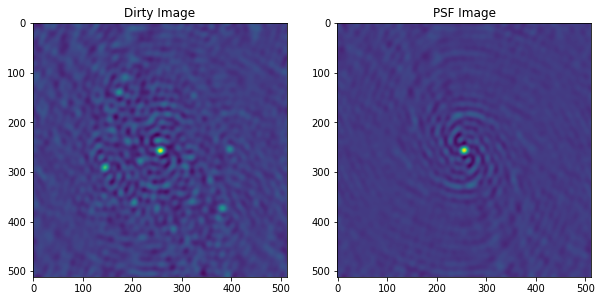

In [36]:
# Plot the dirty image and the PSF
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax1.imshow(dirtyImg, cmap='viridis')
ax1.set_title('Dirty Image')
ax2 = fig.add_subplot(122)
ax2.imshow(psfImg, cmap='viridis')
ax2.set_title('PSF Image')
plt.show()


In [29]:
residImg, skyModel = hogbom(dirtyImg, psfImg, gain, niter, fthresh)

iter 0, (l,m):(257, 256), flux: 9.933646
iter 1, (l,m):(257, 256), flux: 8.941682
iter 2, (l,m):(257, 257), flux: 8.061026
iter 3, (l,m):(257, 256), flux: 7.256326
iter 4, (l,m):(256, 257), flux: 6.548657
iter 5, (l,m):(291, 145), flux: 6.213571
iter 6, (l,m):(257, 257), flux: 5.861333
iter 7, (l,m):(291, 145), flux: 5.558123
iter 8, (l,m):(256, 257), flux: 5.253276
iter 9, (l,m):(291, 145), flux: 4.974764
iter 10, (l,m):(256, 256), flux: 4.704674
iter 11, (l,m):(291, 145), flux: 4.451291
iter 12, (l,m):(257, 257), flux: 4.213285
iter 13, (l,m):(291, 145), flux: 3.981655
iter 14, (l,m):(373, 382), flux: 3.934141
iter 15, (l,m):(139, 173), flux: 3.769646
iter 16, (l,m):(256, 256), flux: 3.762641
iter 17, (l,m):(291, 145), flux: 3.555723
iter 18, (l,m):(373, 382), flux: 3.522405
iter 19, (l,m):(140, 173), flux: 3.395329
iter 20, (l,m):(256, 257), flux: 3.356812
iter 21, (l,m):(362, 203), flux: 3.323198
iter 22, (l,m):(290, 145), flux: 3.181445
iter 23, (l,m):(373, 382), flux: 3.141482
it

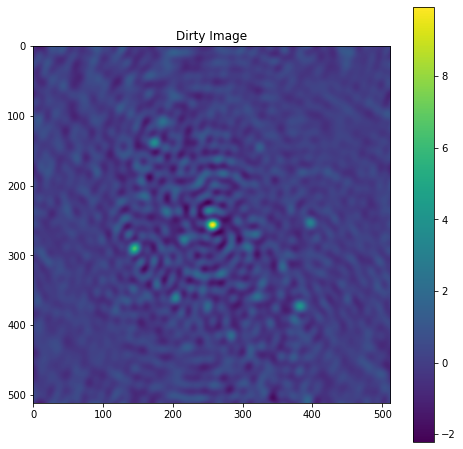

In [31]:
#plot dirty image
fig = plt.figure(figsize=(8,8))
plt.imshow(dirtyImg)
plt.title('Dirty Image')
plt.colorbar()
plt.show()

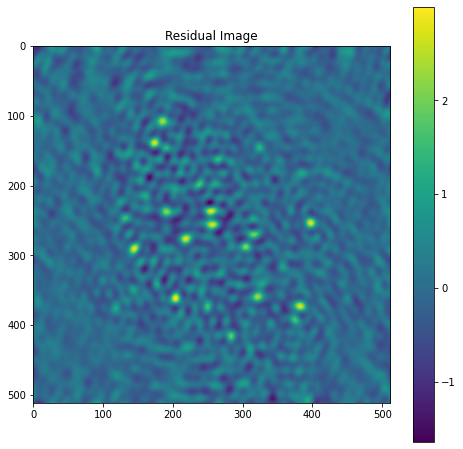

In [32]:
#plot residual image
fig = plt.figure(figsize=(8,8))
plt.imshow(residImg)
plt.title('Residual Image')
plt.colorbar()
plt.show()

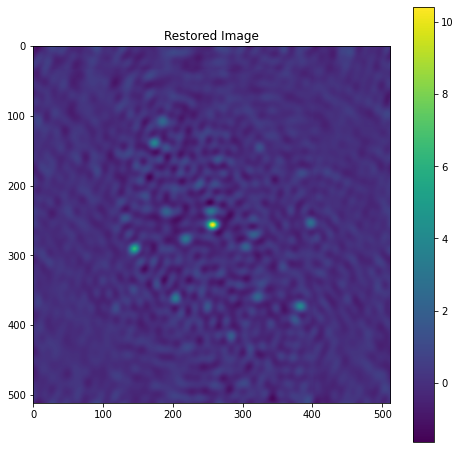

In [33]:
#plot restored image
restImg = restoreImg(skyModel, residImg, idealPSFparams)
fig = plt.figure(figsize=(8,8))
plt.imshow(restImg)
plt.title('Restored Image')
plt.colorbar()
plt.show()